In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

# 01_data_preparation.ipynb ile aynı BASE_DIR
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/Sugarcane Disease"
SPLIT_DIR = os.path.join(BASE_DIR, "dataset_split")

train_dir = os.path.join(SPLIT_DIR, "train")
val_dir   = os.path.join(SPLIT_DIR, "val")
test_dir  = os.path.join(SPLIT_DIR, "test")

print("TRAIN:", train_dir)
print("VAL  :", val_dir)
print("TEST :", test_dir)

print("Train klasörü var mı?", os.path.exists(train_dir))
print("Val   klasörü var mı?", os.path.exists(val_dir))
print("Test  klasörü var mı?", os.path.exists(test_dir))


TRAIN: /content/drive/MyDrive/Colab Notebooks/Sugarcane Disease/dataset_split/train
VAL  : /content/drive/MyDrive/Colab Notebooks/Sugarcane Disease/dataset_split/val
TEST : /content/drive/MyDrive/Colab Notebooks/Sugarcane Disease/dataset_split/test
Train klasörü var mı? True
Val   klasörü var mı? True
Test  klasörü var mı? True


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, matthews_corrcoef,
    precision_recall_fscore_support, classification_report,
    confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import label_binarize


In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Sınıflar:", class_names)
print("Sınıf sayısı:", num_classes)


Found 1762 files belonging to 5 classes.
Found 250 files belonging to 5 classes.
Found 509 files belonging to 5 classes.
Sınıflar: ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']
Sınıf sayısı: 5


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

IMG_SHAPE = IMG_SIZE + (3,)

# Base model (Feature extractor)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

# Pretrained katmanları dondur
for layer in base_model.layers:
    layer.trainable = False

# Üstteki sınıflandırıcı katman
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

vgg16_model = Model(inputs=base_model.input, outputs=output_layer)

vgg16_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,301 (56.64 MB)

 Trainable params: 132,613 (518.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
vgg16_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [8]:
EPOCHS = 15

history_vgg = vgg16_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.2229 - loss: 5.7670 - val_accuracy: 0.3840 - val_loss: 2.1169
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 240ms/step - accuracy: 0.3262 - loss: 3.6459 - val_accuracy: 0.5240 - val_loss: 1.6964
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.4024 - loss: 2.8819 - val_accuracy: 0.5760 - val_loss: 1.3445
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.4865 - loss: 2.0783 - val_accuracy: 0.6240 - val_loss: 1.1964
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.5140 - loss: 1.8317 - val_accuracy: 0.6360 - val_loss: 1.0854
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.5702 - loss: 1.5007 - val_accuracy: 0.6880 - val_loss: 1.0104
Epoch 7/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - accuracy: 0.5618 - loss: 1.4749 - val_accuracy: 0.6680 - val_loss: 0.9695
Epoch 8/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - accuracy: 0.6366 - loss: 1.1992 - val_accura

In [9]:
EPOCHS = 15

history_vgg = vgg16_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.7302 - loss: 0.7365 - val_accuracy: 0.7640 - val_loss: 0.7519
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - accuracy: 0.7818 - loss: 0.6132 - val_accuracy: 0.7560 - val_loss: 0.7455
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - accuracy: 0.7505 - loss: 0.6503 - val_accuracy: 0.7560 - val_loss: 0.7222
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - accuracy: 0.7410 - loss: 0.6748 - val_accuracy: 0.7640 - val_loss: 0.7141
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.7886 - loss: 0.5270 - val_accuracy: 0.7720 - val_loss: 0.7179
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 0.7980 - loss: 0.5595 - val_accuracy: 0.7640 - val_loss: 0.7028
Epoch 7/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.7846 - loss: 0.5657 - val_accuracy: 0.7800 - val_loss: 0.7022
Epoch 8/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - accuracy: 0.7983 - loss: 0.5347 - val_accu

In [10]:
test_loss, test_acc = vgg16_model.evaluate(test_ds)
print(f"VGG16 Test Accuracy: {test_acc:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 116s 7s/step - accuracy: 0.8145 - loss: 0.5693
VGG16 Test Accuracy: 0.7839


In [11]:
import numpy as np

y_true = []
y_pred = []
y_prob = []

for images, labels in test_ds:
    preds = vgg16_model.predict(images)
    y_prob.extend(preds)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


In [12]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_recall_fscore_support,
    matthews_corrcoef, classification_report, confusion_matrix
)

acc = accuracy_score(y_true, y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)

print("=== VGG16 Test Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


=== VGG16 Test Metrics ===
Accuracy: 0.7839
Balanced Accuracy: 0.7823
Precision: 0.7837
Recall: 0.7839
F1-score: 0.7832
MCC: 0.7299

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.85      0.87      0.86       105
      Mosaic       0.79      0.74      0.77        93
      RedRot       0.70      0.76      0.73       105
        Rust       0.90      0.90      0.90       104
      Yellow       0.68      0.64      0.66       102

    accuracy                           0.78       509
   macro avg       0.78      0.78      0.78       509
weighted avg       0.78      0.78      0.78       509



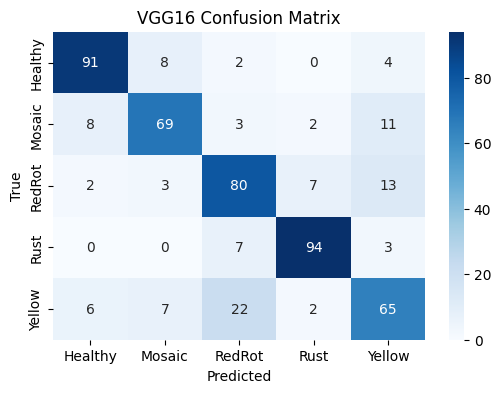

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("VGG16 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


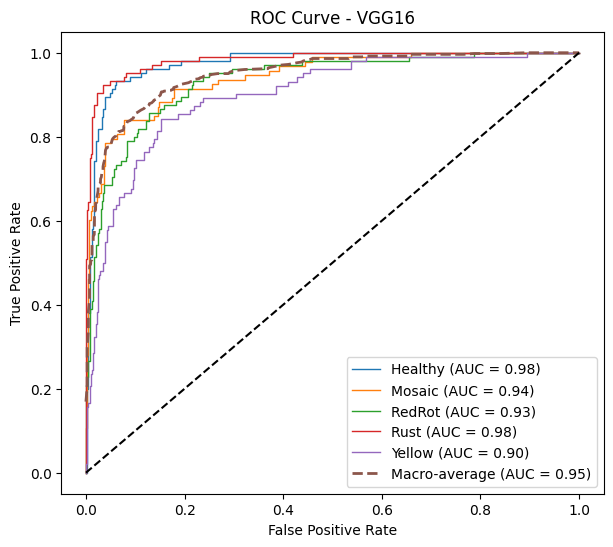

In [14]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_true_bin = label_binarize(y_true, classes=range(num_classes))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(7, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=1,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot(all_fpr, mean_tpr, linestyle='--', lw=2,
         label=f"Macro-average (AUC = {roc_auc['macro']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - VGG16")
plt.legend()
plt.show()


In [15]:
vgg_save_path = os.path.join(BASE_DIR, "vgg16_best_model.h5")
vgg16_model.save(vgg_save_path)

print("VGG16 modeli kaydedildi:", vgg_save_path)


VGG16 modeli kaydedildi: /content/drive/MyDrive/Colab Notebooks/Sugarcane Disease/vgg16_best_model.h5
